# **Image Preprocesing**

#### Preprocessing of the unlabeled image was performed using BaSic plugin in Fiji/ImageJ and the image was saved as "corrected_img"

In [1]:
import os
import cv2
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [3]:
corrected_img = cv2.imread(
    r"C:\Users\sasan\Downloads\Second Projects-20260131T144716Z-3-001\Second Projects\TNT Project\m05_corrected.png",
    cv2.IMREAD_GRAYSCALE
)

In [4]:
print(corrected_img.shape)

(4690, 6278)


In [5]:
print(corrected_img.dtype)

uint8


# **Mask Generation**

In [6]:
labeled_img = cv2.imread(r"C:\Users\sasan\Downloads\Second Projects-20260131T144716Z-3-001\Second Projects\TNT Project\m05-label.png")

In [7]:
hsv = cv2.cvtColor(labeled_img, cv2.COLOR_BGR2HSV)

In [8]:
lower_yellow = np.array([20, 100, 100])
upper_yellow = np.array([35, 255, 255])

In [9]:
tnt_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

# **Binary Label Encoding**

In [10]:
tnt_mask = tnt_mask // 255

In [11]:
tnt_mask.shape

(4690, 6278)

In [12]:
np.unique(tnt_mask)

array([0, 1], dtype=uint8)

In [13]:
cv2.imwrite(
    r"C:\Users\sasan\Downloads\Second Projects-20260131T144716Z-3-001\Second Projects\TNT Project\tnt_mask.png",
    tnt_mask * 255
)

True

In [14]:
tnt_mask = cv2.imread(
    r"C:\Users\sasan\Downloads\Second Projects-20260131T144716Z-3-001\Second Projects\TNT Project\tnt_mask.png",
    cv2.IMREAD_GRAYSCALE
)

# **Patch Extraction**

In [15]:
corrected_img.shape, tnt_mask.shape

((4690, 6278), (4690, 6278))

In [16]:
tnt_mask = tnt_mask // 255

In [17]:
np.unique(tnt_mask)

array([0, 1], dtype=uint8)

In [18]:
def extract_patches(image, mask, patch_size = 256, stride = 128, min_pixels = 50, min_ratio = 0.003):
    patches = []
    h, w = image.shape
    patch_area = patch_size * patch_size

    for y in range(0, h-patch_size+1, stride):
        for x in range(0, w-patch_size+1, stride):
            
            patch = image[y:y+patch_size, x:x+patch_size]
            mask_patch = mask[y:y+patch_size, x:x+patch_size]

            tnt_pixels = np.sum(mask_patch > 0)
            label = int(
                (tnt_pixels >= min_pixels) and
                (tnt_pixels / patch_area >= min_ratio)
            )
            patches.append((patch,label))

    return patches

# **Patch-Level Labeling and Dataset Organization**

In [19]:
patches = extract_patches(corrected_img, tnt_mask, patch_size = 128, stride = 128, min_pixels = 50, min_ratio = 0.003)

In [20]:
print(f'Total patches: {len(patches)}')

Total patches: 1764


In [21]:
tnt_patches = [p for p in patches if p[1] == 1]
no_tnt_patches = [p for p in patches if p[1] == 0]

In [22]:
print(f"TNT patches: {len(tnt_patches)}")

TNT patches: 63


In [23]:
print(f"No-TNT patches: {len(no_tnt_patches)}")

No-TNT patches: 1701


In [24]:
ratio = 5  # 1:5 TNT:no-TNT
k = min(len(no_tnt_patches), ratio * len(tnt_patches))

In [25]:
selected_no_tnt = random.sample(no_tnt_patches, k)

In [26]:
final_patches = tnt_patches + selected_no_tnt
random.shuffle(final_patches)

In [27]:
print(f"Final training patches: {len(final_patches)}")

Final training patches: 378


In [28]:
my_path = r"C:\Users\sasan\Downloads\Second Projects-20260131T144716Z-3-001\Second Projects\TNT Project\Train_data"

In [29]:
tnt_dir = os.path.join(my_path, 'TNT')
no_tnt_dir = os.path.join(my_path, 'no_TNT')

In [30]:
os.makedirs(tnt_dir, exist_ok = True)
os.makedirs(no_tnt_dir, exist_ok = True)

In [31]:
for i, (patch, label) in enumerate(final_patches):
    folder = tnt_dir if label == 1 else no_tnt_dir
    patch_rgb = cv2.cvtColor(patch, cv2.COLOR_GRAY2RGB)

    cv2.imwrite(os.path.join(folder,f'patch{i}.png'), patch_rgb)

# **Model Development**

In [32]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2, 
    rotation_range = 10,
    zoom_range = 0.1,
    brightness_range = [0.8, 1.2]
)

In [33]:
train_generator = train_datagen.flow_from_directory(
    my_path,
    target_size = (224, 224),
    batch_size = 8,
    class_mode = 'binary',
    subset = 'training',
    shuffle = True
)

Found 303 images belonging to 2 classes.


In [34]:
train_generator.class_indices

{'TNT': 0, 'no_TNT': 1}

In [35]:
val_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)

In [36]:
val_generator = val_datagen.flow_from_directory(
    my_path,
    target_size = (224, 224),
    batch_size = 4,
    class_mode = 'binary',
    subset = 'validation',
    shuffle = False
)

Found 75 images belonging to 2 classes.


In [37]:
base_model = VGG16(weights = 'imagenet', include_top = False,
                   input_shape = (224, 224, 3))

In [38]:
for layer in base_model.layers:
    layer.trainable = False

In [39]:
tnt_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation = 'relu'),
    Dropout(0.5),                  
    Dense(1, activation = 'sigmoid')]
)

In [40]:
tnt_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',  # just for fun
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(curve='PR', name='pr_auc')
    ]
)


In [41]:
tnt_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [42]:
history = tnt_model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 14,
    steps_per_epoch = math.ceil(train_generator.samples / train_generator.batch_size),
    validation_steps = math.ceil(val_generator.samples / val_generator.batch_size)
)

Epoch 1/14
38/38 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8284 - loss: 0.4718 - pr_auc: 0.8387 - precision: 0.8311 - recall: 0.9960 - val_accuracy: 0.8400 - val_loss: 0.4217 - val_pr_auc: 0.9503 - val_precision: 0.8400 - val_recall: 1.0000
Epoch 2/14
38/38 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.8317 - loss: 0.4575 - pr_auc: 0.8589 - precision: 0.8317 - recall: 1.0000 - val_accuracy: 0.8400 - val_loss: 0.4158 - val_pr_auc: 0.9509 - val_precision: 0.8400 - val_recall: 1.0000
Epoch 3/14
38/38 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8218 - loss: 0.4327 - pr_auc: 0.8938 - precision: 0.8300 - recall: 0.9881 - val_accuracy: 0.8400 - val_loss: 0.4126 - val_pr_auc: 0.9504 - val_precision: 0.8400 - val_recall: 1.0000
Epoch 4/14
38/38 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8383 - loss: 0.4174 - pr_auc: 0.8980 - precision: 0.8418 - recall: 0.9921 - val_accuracy: 0.8267 - val_loss: 0.4089 - val_pr_auc: 0.9512 - val_precision: 0.8378 - val_recall: 0.9841
Epoch 5/14
38/38

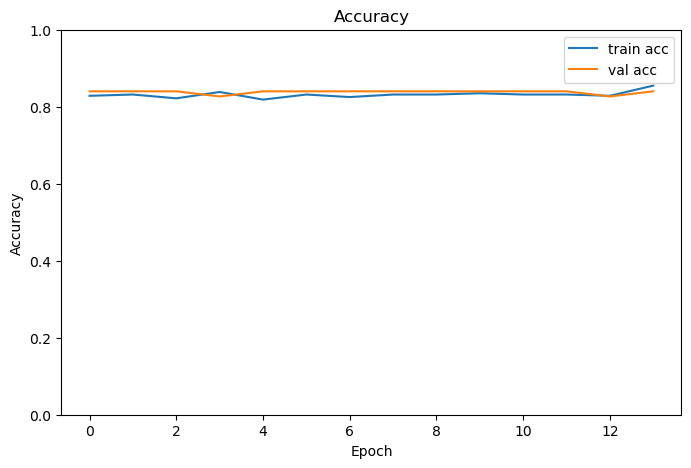

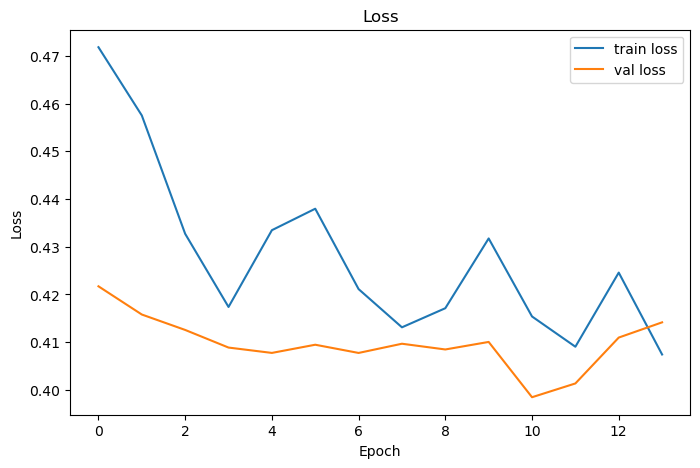

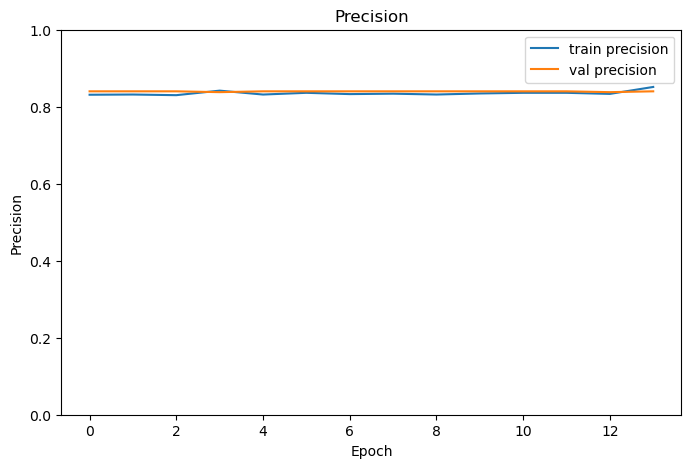

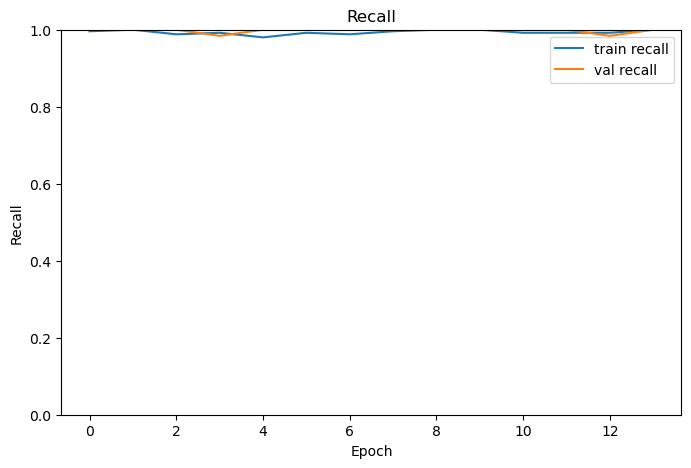

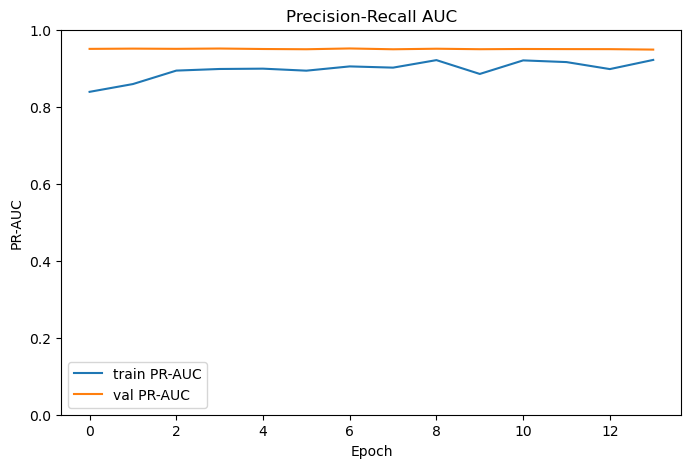

In [43]:
# Plot Accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.ylim(0,1)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.show()

# Plot Precision
plt.figure(figsize=(8,5))
plt.plot(history.history['precision'], label='train precision')
plt.plot(history.history['val_precision'], label='val precision')
plt.ylim(0,1)
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.title("Precision")
plt.legend()
plt.show()

# Plot Recall
plt.figure(figsize=(8,5))
plt.plot(history.history['recall'], label='train recall')
plt.plot(history.history['val_recall'], label='val recall')
plt.ylim(0,1)
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.title("Recall")
plt.legend()
plt.show()

# Plot PR-AUC (if you tracked it)
plt.figure(figsize=(8,5))
plt.plot(history.history['pr_auc'], label='train PR-AUC')
plt.plot(history.history['val_pr_auc'], label='val PR-AUC')
plt.ylim(0,1)
plt.xlabel("Epoch")
plt.ylabel("PR-AUC")
plt.title("Precision-Recall AUC")
plt.legend()
plt.show()


In [44]:
tnt_model.save("tnt_vgg16_patch_classifier_256.keras")

# **Heatmap Generation**

In [45]:
def tnt_heatmap(model, image, patch_size = 512, stride = 128):
    h, w = image.shape
    heatmap = np.zeros((h,w))
    counts = np.zeros((h,w))

    for y in range(0, h-patch_size+1, stride):
        for x in range(0, w-patch_size+1, stride):
            
            patch = image[y:y+patch_size, x:x+patch_size]
            patch = cv2.resize(patch, (224,224))       #Resize for VGG
            patch = patch / 255.0                      #Normalize
            patch = np.stack([patch]*3, axis = -1)     #Convert grayscale to RGB
            patch = np.expand_dims(patch, axis = 0)    #Add batch dimension 

            prob = 1 - (model.predict(patch, verbose = 0)[0][0])

            heatmap[y:y+patch_size, x:x+patch_size] += prob
            counts[y:y+patch_size, x:x+patch_size] += 1
            
    heatmap /= np.maximum(counts, 1)
    return heatmap

In [46]:
heatmap = tnt_heatmap(tnt_model, corrected_img)

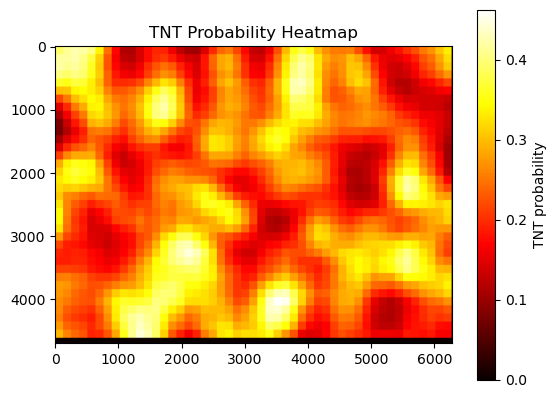

In [47]:
plt.imshow(heatmap, cmap='hot')
plt.colorbar(label="TNT probability")
plt.title("TNT Probability Heatmap")
plt.show()

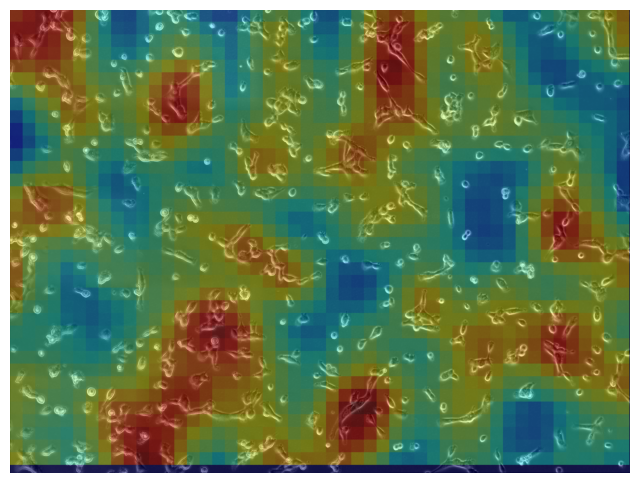

In [48]:
plt.figure(figsize=(8, 8))
plt.imshow(corrected_img, cmap='gray')
plt.imshow(heatmap, cmap='jet', alpha=0.4)
plt.axis('off')
plt.show()